In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.append('../')
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

# check to make sure you set the device
torch.cuda.set_device(0)

### Setup Globals

In [19]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

### Define Common Functions (very similar to the first pascal model)

In [20]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)
    

### Setup Multiclass

In [21]:
trn_anno = get_trn_anno()
MC_CSV = PATH/'tmp/mc.csv'

mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [22]:
df.head()

fn              clas
0  000012.jpg               car
1  000017.jpg      person horse
2  000023.jpg    bicycle person
3  000026.jpg               car
4  000032.jpg  person aeroplane

### Setup Resnet Model and Train

In [23]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.326271   16.738022  0.394231  



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.326659   0.138878   0.954184  
    1      0.174125   0.078377   0.973558                  
    2      0.11821    0.074982   0.974654                  



[0.07498233, 0.9746544435620308]

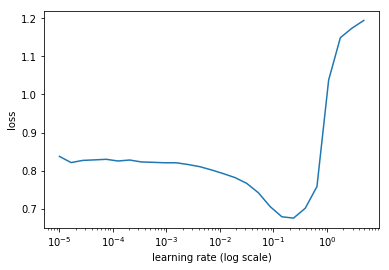

In [24]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

# find learning rate
lrf=learn.lr_find(1e-5,100)

# plot the learning rate to visually choose
learn.sched.plot(0)

# select learning rate
lr = 2e-2

# fit the model
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:07<00:01,  3.42it/s, loss=0.33]  


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.070927   0.081387   0.972078  
    1      0.052779   0.078058   0.974429                   
    2      0.038978   0.078155   0.974745                   
    3      0.027514   0.074822   0.977141                   
    4      0.019513   0.075868   0.977652                   



[0.075868085, 0.9776517376303673]

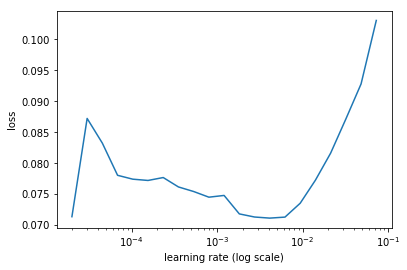

In [25]:
# define learning rates to search
lrs = np.array([lr/100, lr/10, lr])

# freeze the model till teh last 2 steps as before:
learn.freeze_to(-2)

# find the optimal learning rate again
learn.lr_find(lrs/1000)
learn.sched.plot(0)

# refit the model
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

### Save the model

In [26]:
learn.save('mclas')
learn.load('mclas')

## multiple Bbox per cell

In [27]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

### Create Lookups and reference objects

- **`mc`** - list of items found per image
- **`mcs`** - list of items found per image, but the ID
- **`id2cat`** - numeric value to category
- **`cat2id`** - category to id

In [28]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [29]:
# get cross validation ids
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

### Create and Save multiple Bounding boxes 

In [30]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [31]:
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

### Setup Dataset

In [32]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

### Create our Dataset with 2 associated Labels

In [33]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [34]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

### Setup some plotting functions 

In [35]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

### View the Sample labels

In [36]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

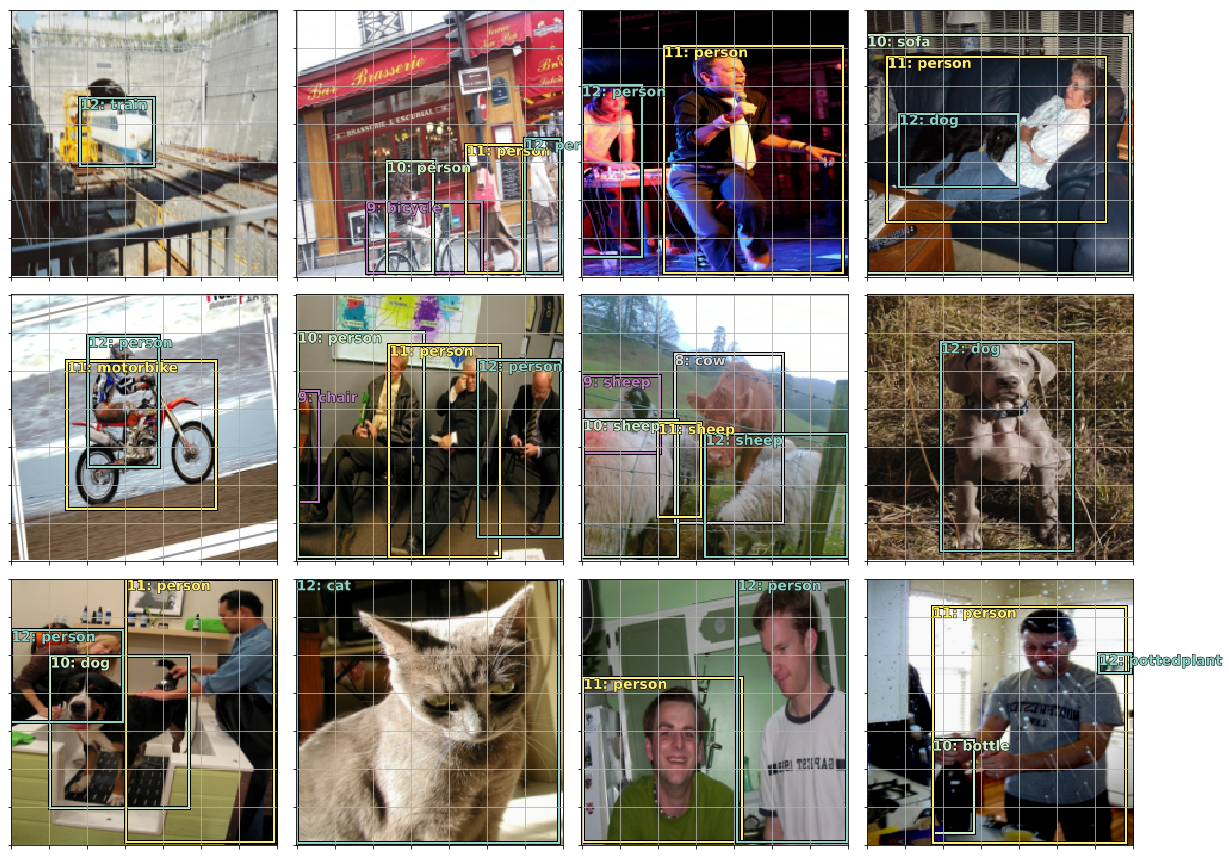

In [37]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Make a model to predict what shows up in a 2x2 grid

- **`anc_grid`** = how big of a square grid to make (subdivision)
- **`anc_offset`** = center offsets
- **`anc_x`** = x coordinates for centers
- **`anc_y`** = y coordinates for centers
- **`anc_ctrs`** - the actual coordinates for the grid centers
- **`anc_sizes`** - size of the quadrants

In [53]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [54]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

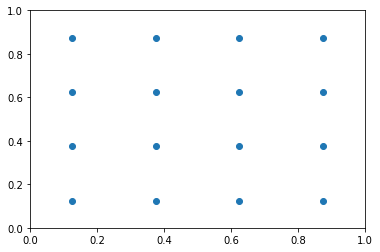

In [55]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [56]:
#anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [57]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [58]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

### This is a simple Conv Model

In [81]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

### This is an output Conv Model with 2 Conv2d layers

In [82]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

### The SSD  Model

- **`Stride 1 Convolution`** - doesn't change the dimension size, but we have a mini neural network
- **`StdConv`** - a combination block of **`Conv2d`**, **`BatchNorm`**, **`Dropout`** defined above.
- **`OutConv`** - a combination block of **`Conv2d, 4 x Stride 1 `**, **`Conv2d,  C x Stride 1`** with two layers we are outputting `4 + C`

Note that we are adding one more class for background.

In [83]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)


head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

### How do we write a loss function for this?

- Has to look at each of these **16 sets** of activations, which will each have **4 bounding box** and **categories + 1**
- The loss function actually needs to take each object in the image and match them to a convolutional grid cell. This is called the **matching problem**

In [84]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

### Reminder - 4x4 quadrants there's 20 classes, 1 background + 4 channels

```
	fn	bbox
0	000012.jpg	96 155 269 350
1	000017.jpg	61 184 198 278 77 89 335 402
```

Feeds a high number if it IS a good reflection, and a low number is lower.

In [85]:
def intersect(box_a, box_b):
    """ Returns the intersection of two boxes """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Returns the box size"""
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Returns the jaccard distance between two boxes"""
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    """ ??? """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    """ activations to bounding boxes """
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """ ?? """
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

### Test to make sure that model works

In [86]:
x,y = next(iter(md.val_dl))
#x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [89]:
learn.model.cuda()
batch = learn.model(x)
#ssd_loss(batch, y, True)

In [91]:
learn.model.cuda()
batch = learn.model(x)

In [92]:
type(batch[0].data), type(y[0].data)

(torch.cuda.FloatTensor, torch.cuda.FloatTensor)

### Train the model

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      178.904678 179954.0  



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      41.900517  30.778248 



HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      31.734285  29.830471 
    1      29.553838  28.571745                           
    2      27.744743  26.556757                           
    3      26.028599  26.084572                           
    4      24.452854  25.413759                           



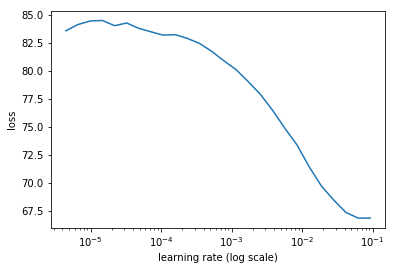

In [93]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)
learn.fit(lr, 1, cycle_len=1, use_clr=(20,3))

learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))
learn.save('0')

In [94]:
learn.load('0')

## Let's walk through a Loss Function

In [95]:
# grab a single batch
x,y = next(iter(md.val_dl))

# turn into variables
x,y = V(x),V(y)

# set model to eval mode (trained in the previous block)
learn.model.eval()
batch = learn.model(x)

# destructure the class and the bounding box
b_clas,b_bb = batch

#### The dimensions

- **64** Batch size by 
- **16** Grid cells
- **21** classes
- **4** Bounding Box coord



In [96]:
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

#### Looking at image 7

In [97]:
idx=7

# class
b_clasi = b_clas[idx]

# bounding box
b_bboxi = b_bb[idx]

# image
ima=md.val_ds.ds.denorm(to_np(x))[idx]

# bounding box / classification
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

#### Truth of Image 7

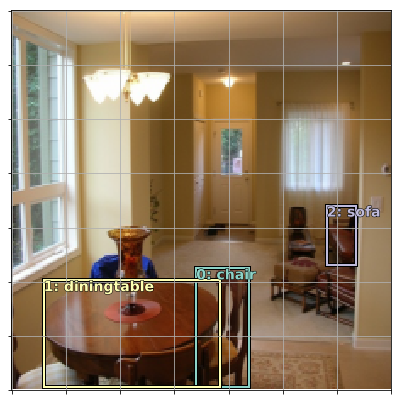

In [98]:
# Convert torch tensors to numpy
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

#### Look at our 16 anchor boxes

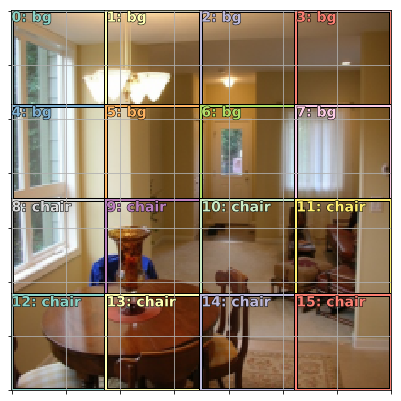

In [99]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

#### Let's look at the sofa
<img src='https://snag.gy/STNDeW.jpg' width='600px' />

Lets look at the area of intersection with boxes 7 and 11

<img src='https://snag.gy/VnG6CI.jpg' width='300px' />

The **Jaccard** index will be the area of intersection over the area over union. In this picture it is the green area over green + yellow. Higher jaccard index = higher intersection

### For Every object ( 0 Chair, 1 Dining, 2 Sofa) we will compare and calc Jaccard index, result is 3x16 matrix

#### Lets first look at the anchor coordinates. `center x | center y | height | width`

In [100]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

#### Get the activtions

In [111]:
a_ic = actn_to_bb(b_bboxi, anchors)

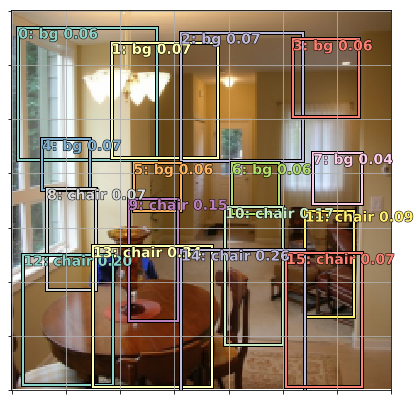

In [112]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

#### Calculate Jaccard index (all objects x all grid cells)

In [101]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

#### For each object, we can find the highest overlap with any cell

**Returns:**
- Maximum amount
- And the corresponding cell index

In [102]:
# Dining Table
overlaps.max(1)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [103]:
# Chair
overlaps.max(0)

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  0.1897
  0.2598
  0.4538
  0.3985
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

#### Combine overlaps with `map_to_ground_truth`

- Object gets assigned to a cell if it has maximum value
- Remaining cells get assigned to objects that have 0.5 or more
- All others are considered backgrounds

In [105]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

### Convert to Classes

In [106]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

### Output 3 Classes predicted

In [108]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

#### Show the Cell Assignment

In [109]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

### End the Matching Stage


**`loc_loss = L1_loss = mean(|matched_activations - ground truth|)`**

In [113]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(Variable containing:
 1.00000e-02 *
   5.8389
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.8217
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

### Let's plot a few pictures

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


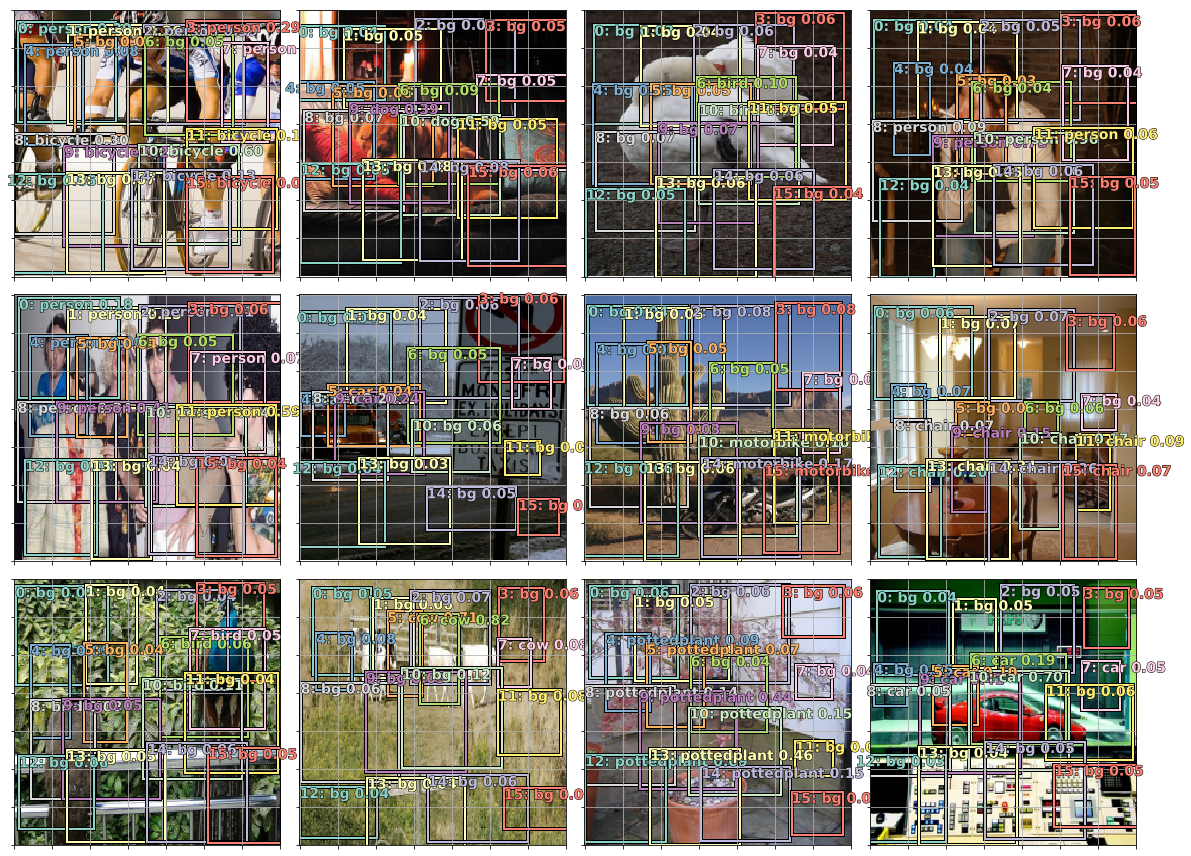

In [114]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

## How do we interpret Activations?

Each predicted bounding box, can be moved up to 50%, twice or half as large. We have to convert the activations into a scaling.

```python
def actn_to_bb(actn, anchors):
    """ activations to bounding boxes """
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)
```
---
Each box can only have one object associated with it. Its possible for an anchorbox to have NOTHING in it. We could:
1. treat background as a class - difficult, because its asking the NN to say 'does this square NOT have 20 other things'
2. BCE loss, checks by process of elimination - if there's no 20 objecst detected, then its background (0 positives)

--- 

```python
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))
```

### SSD Loss

```python

# total SSD loss for batch
def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs
    
# SSD loss for one image
def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    
    # get bounding box and classes
    bbox,clas = get_y(bbox,clas)
    
    # activations to bounding box
    a_ic = actn_to_bb(b_bb, anchors)
    
    # calculate overlaps
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    
    # get the overlaps based on the criteria
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    
    # get the classes
    gt_clas = clas[gt_idx]
    
    # find the positives
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    
    # do the cell assignments
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    
    # calc L1 loss and cross entropy loss
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss
```

## How can we improve?

Let's increase the resolution of the anchor boxes.

### Create Anchor Boxes of different sizes / Aspect Ratios ( 3 aspect ratios, 3 zooms)

<img src='https://snag.gy/Q4xmsU.jpg' width='300px' />

### Use more conv. layers as source of anchor boxes

4 x 4 , 2 x 2, 1 x 1

<img src='https://snag.gy/pPRWft.jpg' width='300px' />

### We can combine the methods to create a LOT of anchor boxes

In [117]:
# Grid cell sizes
anc_grids = [4,2,1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

### Make the Corners

In [118]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

### Make the Dimensions

In [119]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

### Change our Architecture, so it spits out enough activations, Sample of Ground Truth
<img src='https://snag.gy/EfV312.jpg' style='width:400px'/>

### Try to make the activations who closely represents the bounding box
<img src='https://snag.gy/BgTmNQ.jpg' style='width:600px'/>

- Now we can have multiple anchor boxes per grid cell
- For every object, have to figure out which anchor box which is closer
- For each anchor box, we have to find which object its responsible for 
- We don't need to necessarily change the number of Conv. Filters. We will get these for free

## For ground truth boxes = n x (4 + c)



### here's the Model

- **`k`** = number of zooms x number of aspect ratios. Grids will be for free
- **Note the number of `OutConv`** there's many more outputs this time around

In [121]:
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias, drop=0.1):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      436.807953 900833.375



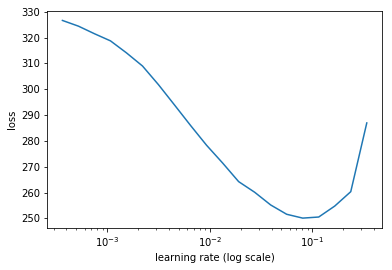

In [123]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [124]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      153.950207 126.174835
    1      119.084206 96.903702                          
    2      99.650275  86.885757                           
    3      86.064523  81.786957                           



[81.78696]

In [125]:
learn.save('tmp')
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      81.888921  154.412491
    1      77.393581  86.504921                           
    2      69.236292  77.665382                           
    3      61.646758  74.613998                           



[74.614]

### Lets look at a batch with probability 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


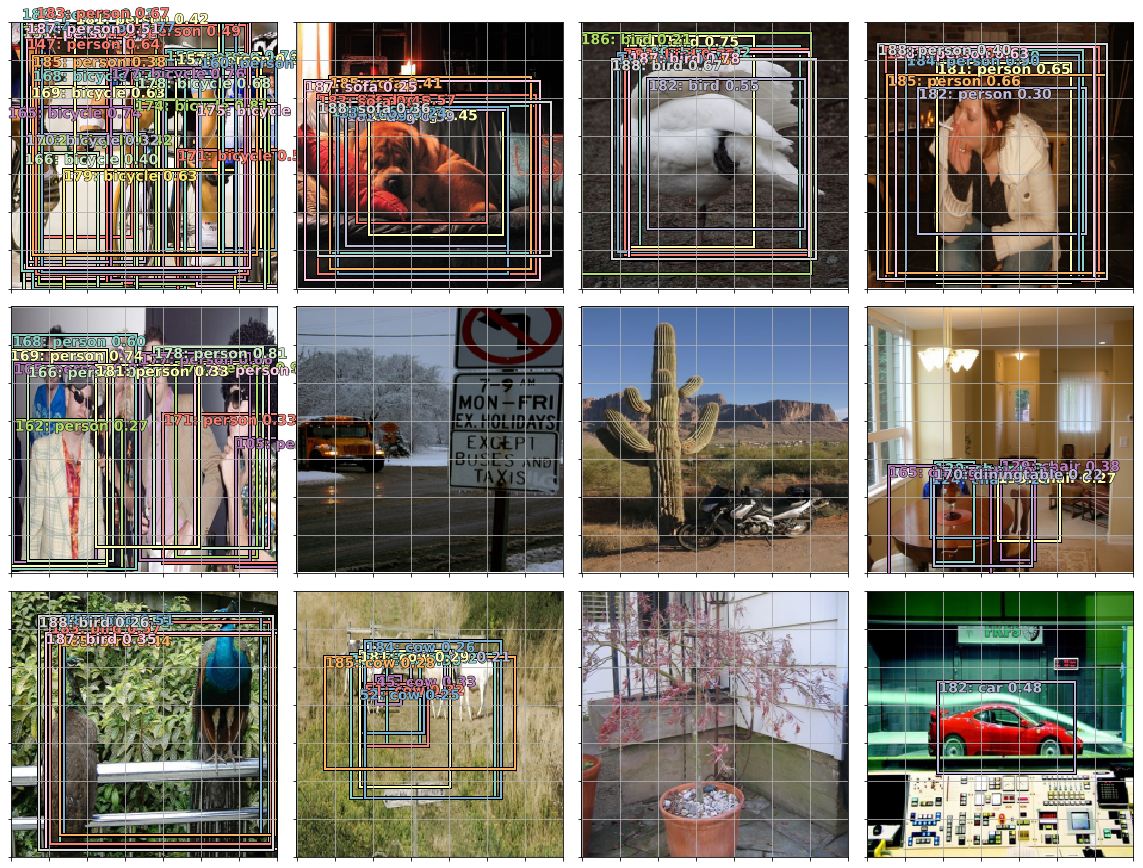

In [126]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.2)
plt.tight_layout()

## Rich History of Object Detection

<img src='https://snag.gy/NglS9i.jpg' style='width:600px'/>

- **2013** - Multibox method paper. You can have a loss function with a matching process
- **[Ross Girshick](http://www.rossgirshick.info/)** - one conv net makes region proposals, one conv net, fed each region into a separate classifier **FAST RCNN**
- **YOLO & SSD** - multibox, but cut through the clutter
- **2017 - FOCAL LOSS RetinaNet** - the messy crap doesn't work. 


### Where's the bike!?

<img src='https://snag.gy/MJ3GZN.jpg' style='width:300px'/>

If you have a 1 x 1, there's a good chance you will find an image. If you have a 4 x 4 search, there's a reduced chance that an object. 

### Why overlapping + large numbers of anchor boxes?

The jacarrad index calculation makes it difficult to achieve over 0.5 without different sized boxes.

Consider reading the paper.
[Paper](https://arxiv.org/pdf/1708.02002.pdf)

<img src='https://snag.gy/8Ro4hP.jpg' style='width:400px' />

Considering the blue line, even if we are at 0.6 confident, the loss is still pretty high. You can't simply say its "not background" you have to be confident its one of the 20 classes. So for smaller objects, its not confident enough. Thats also why the boxes are so big for some objects.

So they suggest a **new loss function** - purple line. The **FL** function is a scaling function of cross entropy loss

It is amazing that the solution is very elegant, and very straightforward in execution.

<img src='https://snag.gy/XiuKJM.jpg' style='width:400px' />

### How to deal with Class imbalance
<img src='https://snag.gy/tjzKLi.jpg' style='width:400px' />

### Then they define Focal Loss with Class weighting
<img src='https://snag.gy/k2voea.jpg' style='width:400px' />

## Focal Loss

In [127]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [129]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

### Retrain the model

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:18<00:01,  1.53it/s, loss=53.9]

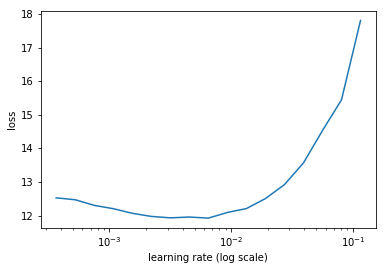

In [130]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [131]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                    


Exception in thread Thread-57:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      14.627009  27.391459 
    1      17.046875  55.384224                           
    2      15.914187  15.103384                           
    3      14.135144  13.905497                           
    4      12.67438   12.506262                           
    5      11.445519  13.349274                           
    6      10.465744  11.700116                           
    7      9.644463   11.588182                           
    8      8.954488   11.204657                           
    9      8.42627    11.142858                           



[11.142858]

In [132]:
learn.save('fl0')

In [133]:
learn.load('fl0')

In [ ]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      7.77895    11.484667 
 47%|████▋     | 15/32 [00:11<00:12,  1.34it/s, loss=7.89]

In [ ]:
learn.save('drop4')
learn.load('drop4')

In [ ]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y, True)
plot_results(0.75)

## Non-Maximum Suppression 

- Will review the different boxes and compares if the boxes overlap a lot, and if they predict the same thing, and will eliminate the duplicate with the lower p-value.
